# Anomaly detection in time series data

## Ways to detect anomaly detection

### Distribution plots of energy consumption by COMED

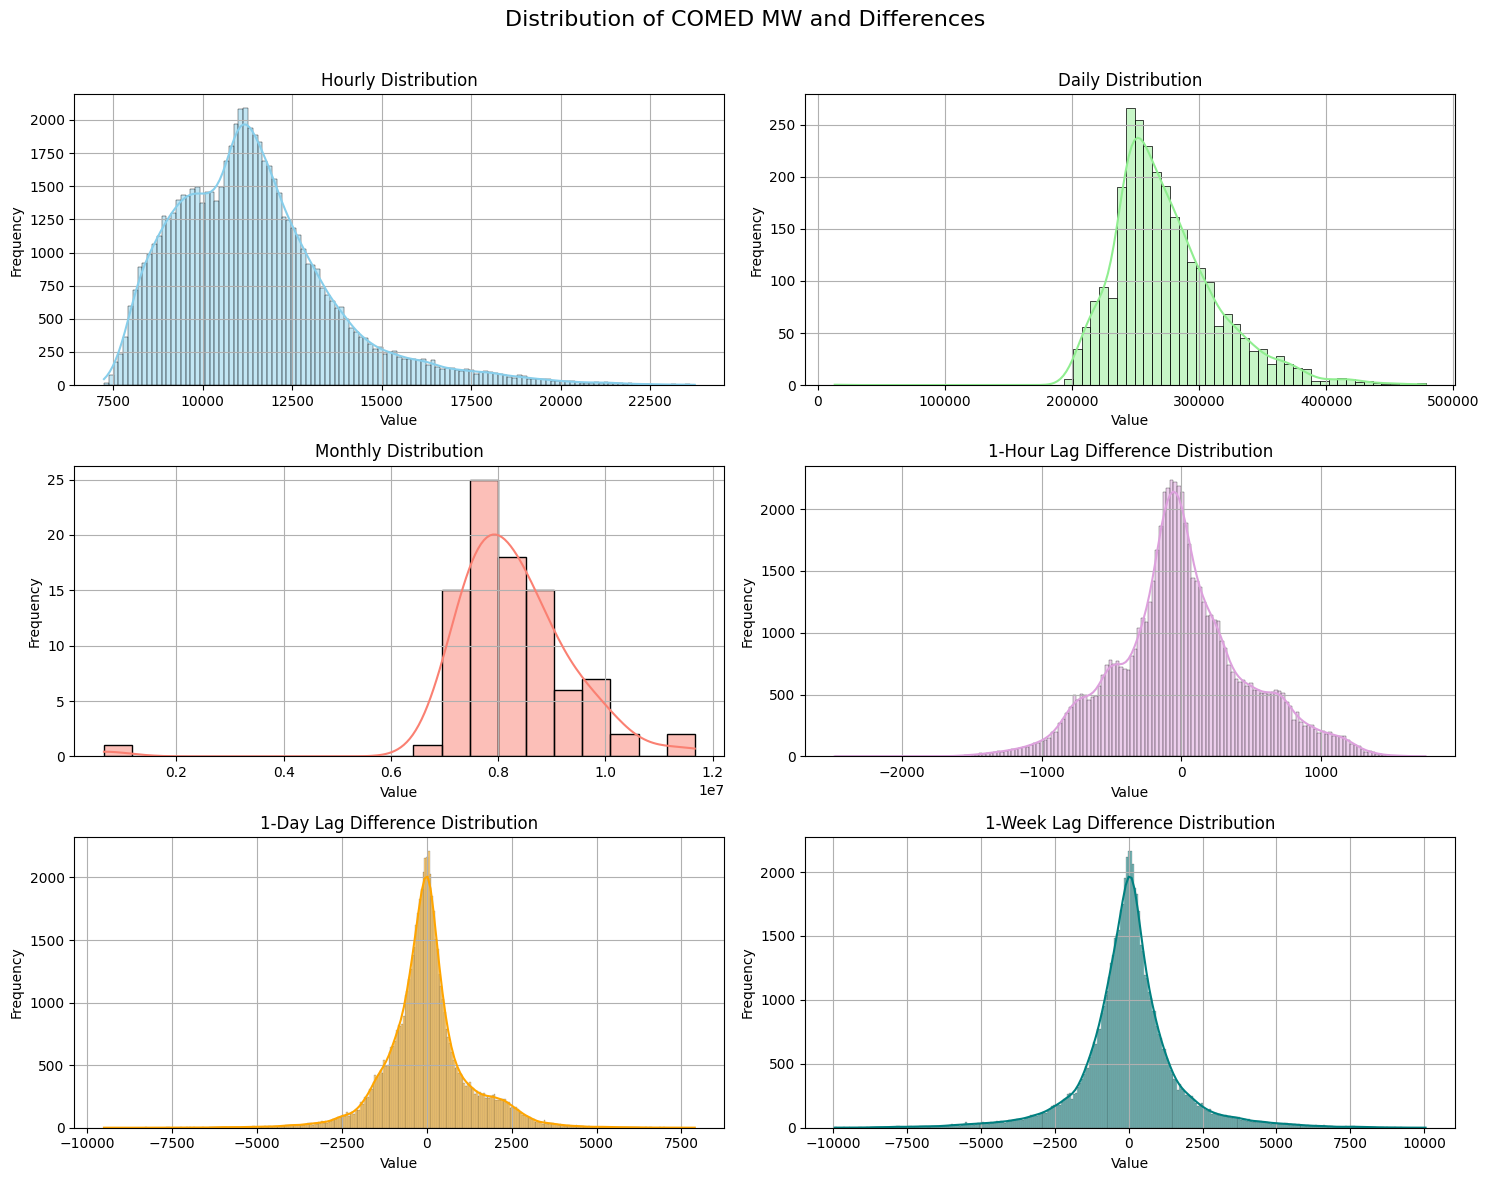

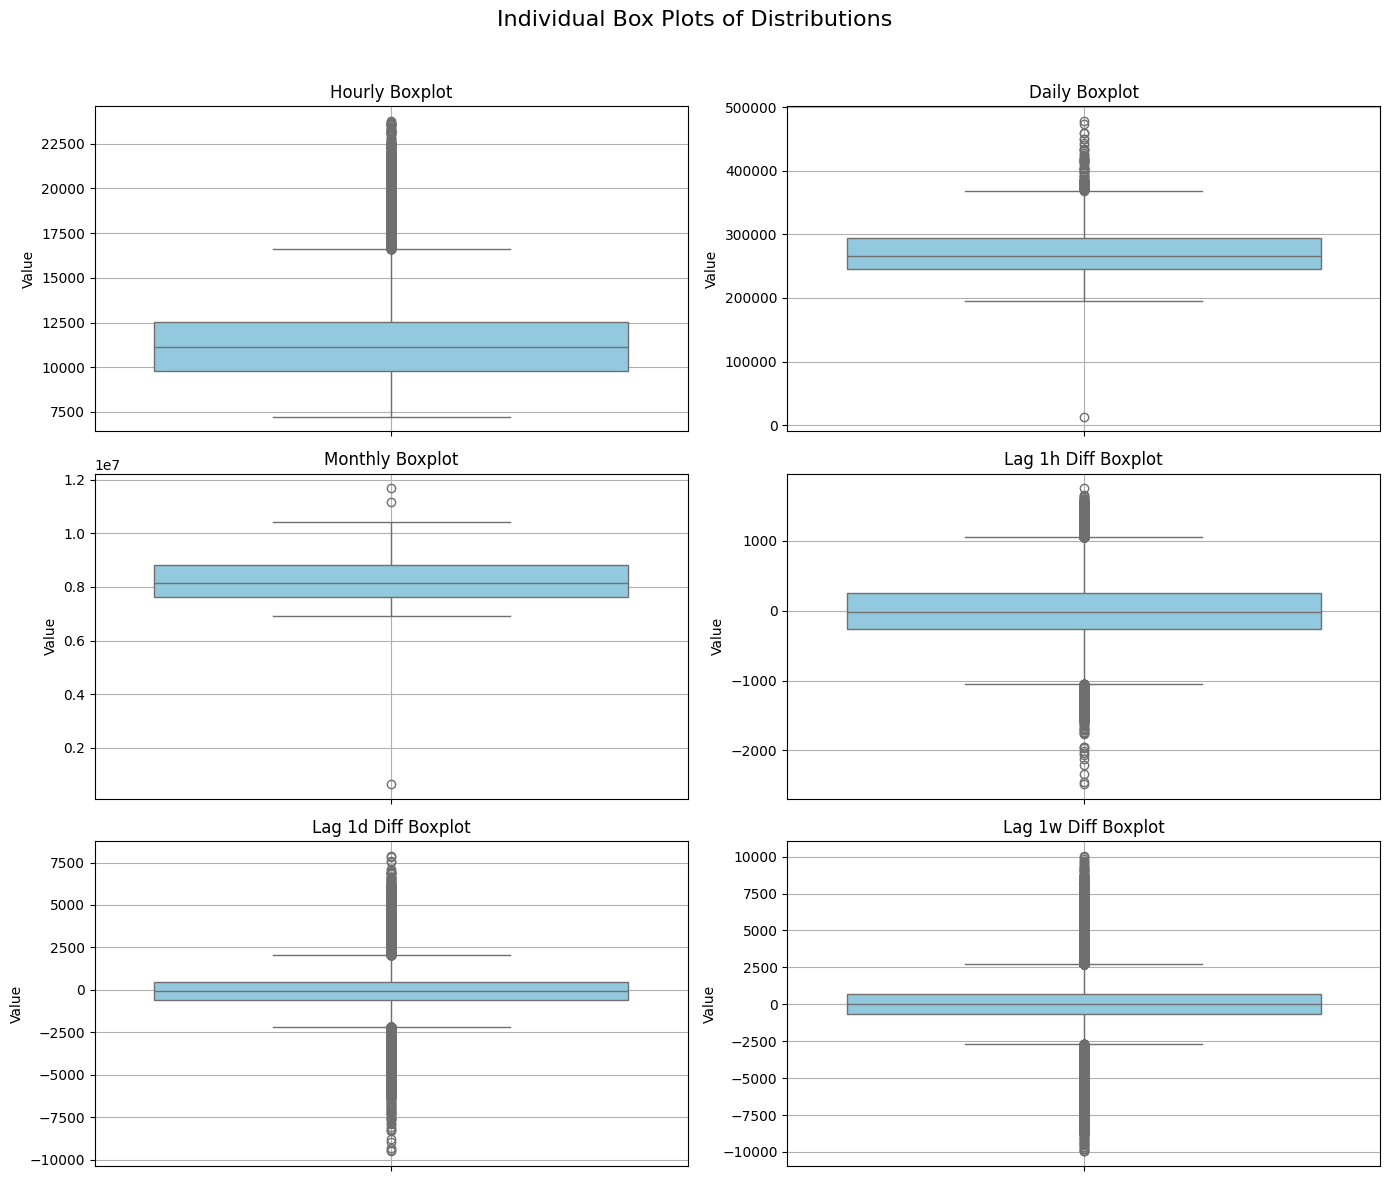

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("COMED_hourly.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)

# Utility: Plot function
def plot(df, column='COMED_MW', window=30):
    return pd.DataFrame({
        'Datetime': df['Datetime'],
        'value': df[column]
    })

# === 1. Hourly ===
hourly = df.copy()
hourly_result = plot(hourly, window=24*7)  # 1 week window

# === 2. Daily ===
daily = df.resample('D', on='Datetime').sum().reset_index()
daily_result = plot(daily, column='COMED_MW', window=30)

# === 3. Monthly ===
monthly = df.resample('ME', on='Datetime').sum().reset_index()
monthly_result = plot(monthly, column='COMED_MW', window=6)

# === 4. 1-hour lag ===
df['lag_1h'] = df['COMED_MW'].shift(1)
df['diff_1h'] = df['COMED_MW'] - df['lag_1h']
lag1h_result = plot(df.dropna(subset=['diff_1h']), column='diff_1h', window=24*7)

# === 5. 1-day lag ===
df['lag_1d'] = df['COMED_MW'].shift(24)
df['diff_1d'] = df['COMED_MW'] - df['lag_1d']
lag1d_result = plot(df.dropna(subset=['diff_1d']), column='diff_1d', window=24*7)

# === 6. 1-week lag ===
df['lag_1w'] = df['COMED_MW'].shift(24*7)
df['diff_1w'] = df['COMED_MW'] - df['lag_1w']
lag1w_result = plot(df.dropna(subset=['diff_1w']), column='diff_1w', window=24*7)

def plot_distributions():
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Distribution of COMED MW and Differences", fontsize=16)

    # 1. Hourly
    sns.histplot(hourly_result['value'], kde=True, ax=axs[0, 0], color='skyblue')
    axs[0, 0].set_title("Hourly Distribution")

    # 2. Daily
    sns.histplot(daily_result['value'], kde=True, ax=axs[0, 1], color='lightgreen')
    axs[0, 1].set_title("Daily Distribution")

    # 3. Monthly
    sns.histplot(monthly_result['value'], kde=True, ax=axs[1, 0], color='salmon')
    axs[1, 0].set_title("Monthly Distribution")

    # 4. 1-Hour Lag Difference
    sns.histplot(lag1h_result['value'], kde=True, ax=axs[1, 1], color='plum')
    axs[1, 1].set_title("1-Hour Lag Difference Distribution")

    # 5. 1-Day Lag Difference
    sns.histplot(lag1d_result['value'], kde=True, ax=axs[2, 0], color='orange')
    axs[2, 0].set_title("1-Day Lag Difference Distribution")

    # 6. 1-Week Lag Difference
    sns.histplot(lag1w_result['value'], kde=True, ax=axs[2, 1], color='teal')
    axs[2, 1].set_title("1-Week Lag Difference Distribution")

    for ax in axs.flat:
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_distributions()

# Create a dictionary of the data
data = {
    'Hourly': hourly_result['value'],
    'Daily': daily_result['value'],
    'Monthly': monthly_result['value'],
    'Lag 1h Diff': lag1h_result['value'],
    'Lag 1d Diff': lag1d_result['value'],
    'Lag 1w Diff': lag1w_result['value'],
}

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Individual Box Plots of Distributions", fontsize=16)

# Plot each boxplot individually
for ax, (label, values) in zip(axs.flat, data.items()):
    sns.boxplot(y=values, ax=ax, color='skyblue')
    ax.set_title(f"{label} Boxplot")
    ax.set_ylabel("Value")
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 1. Z score

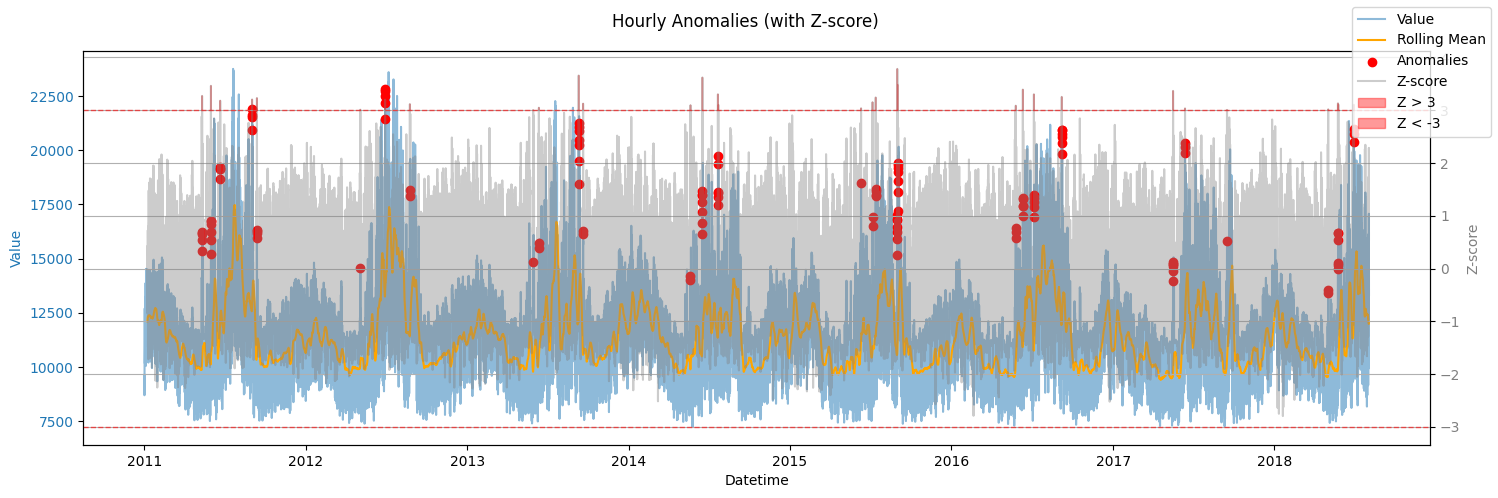

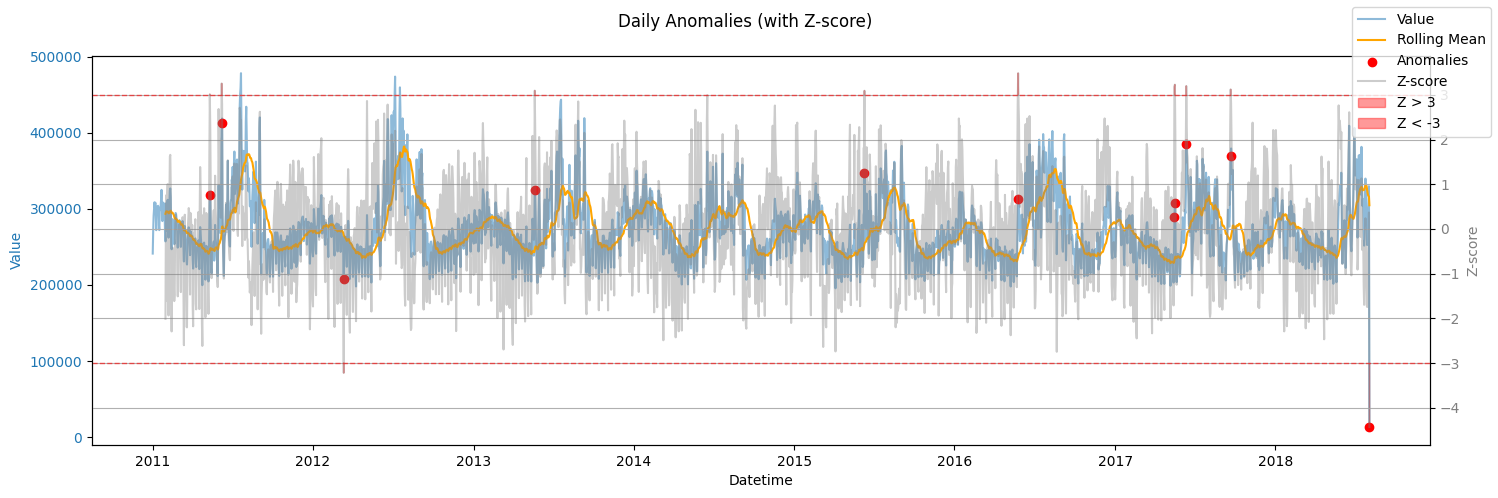

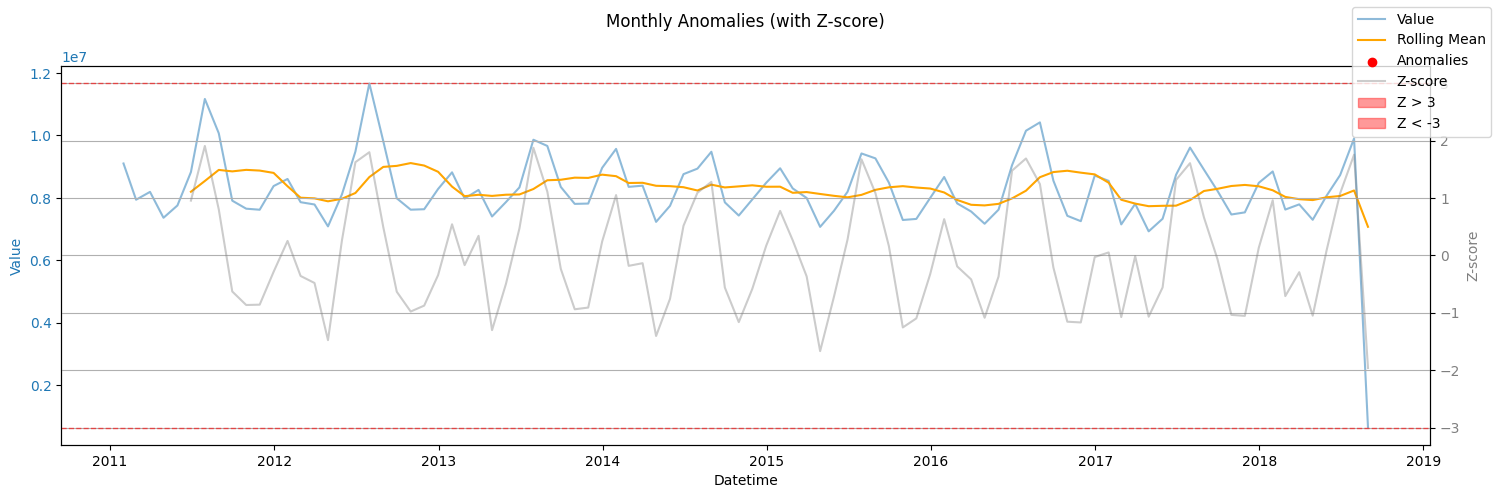

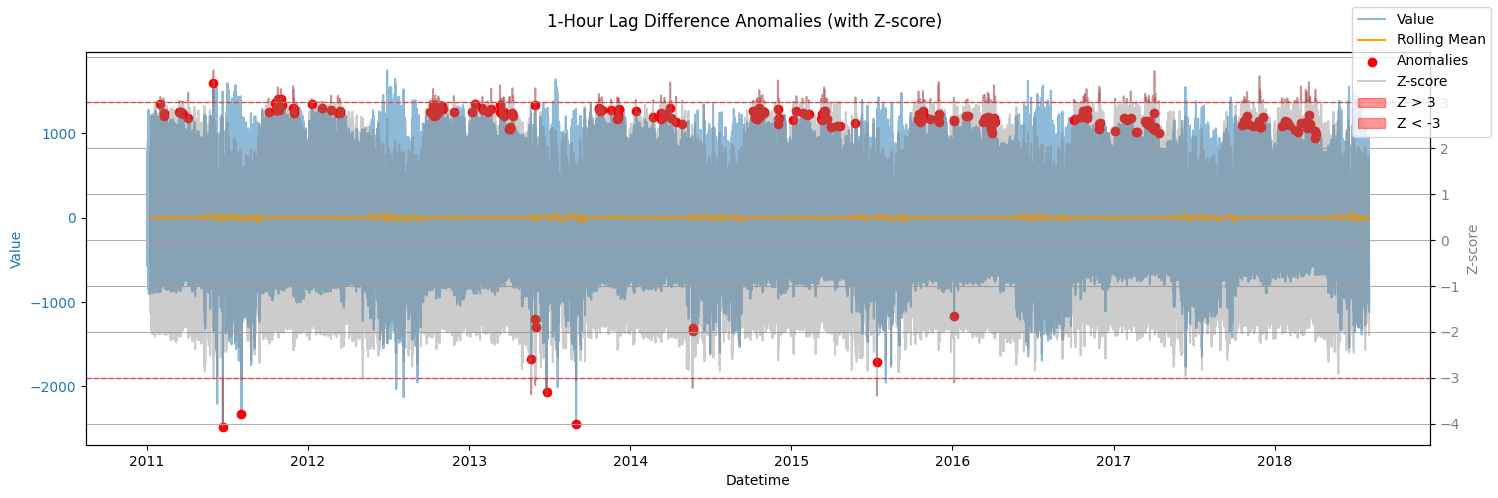

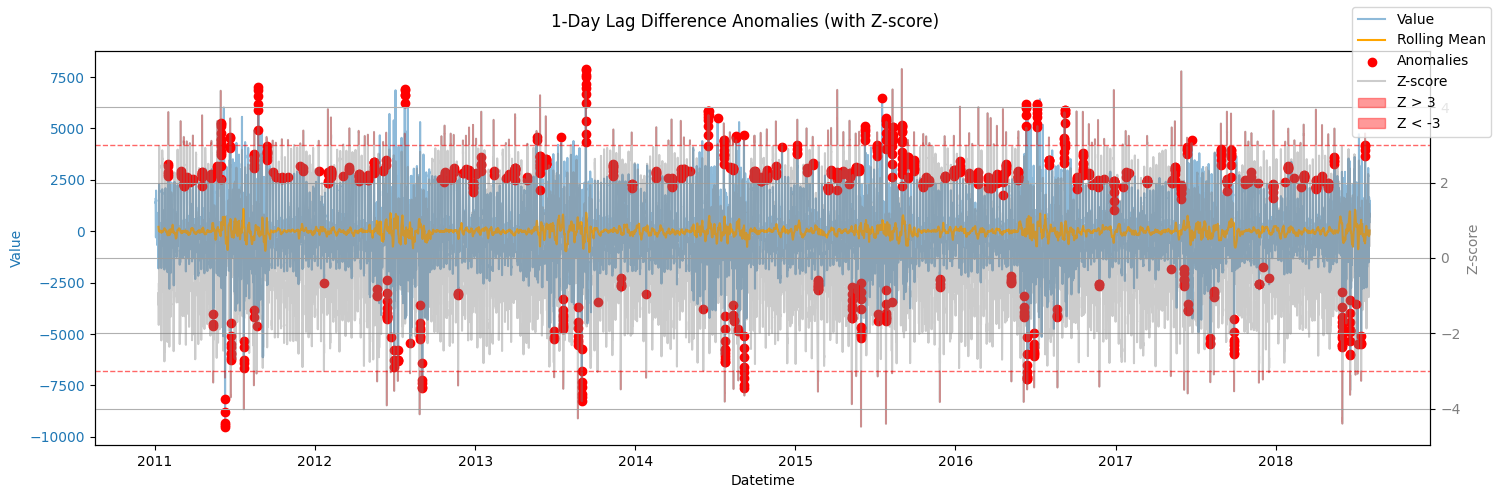

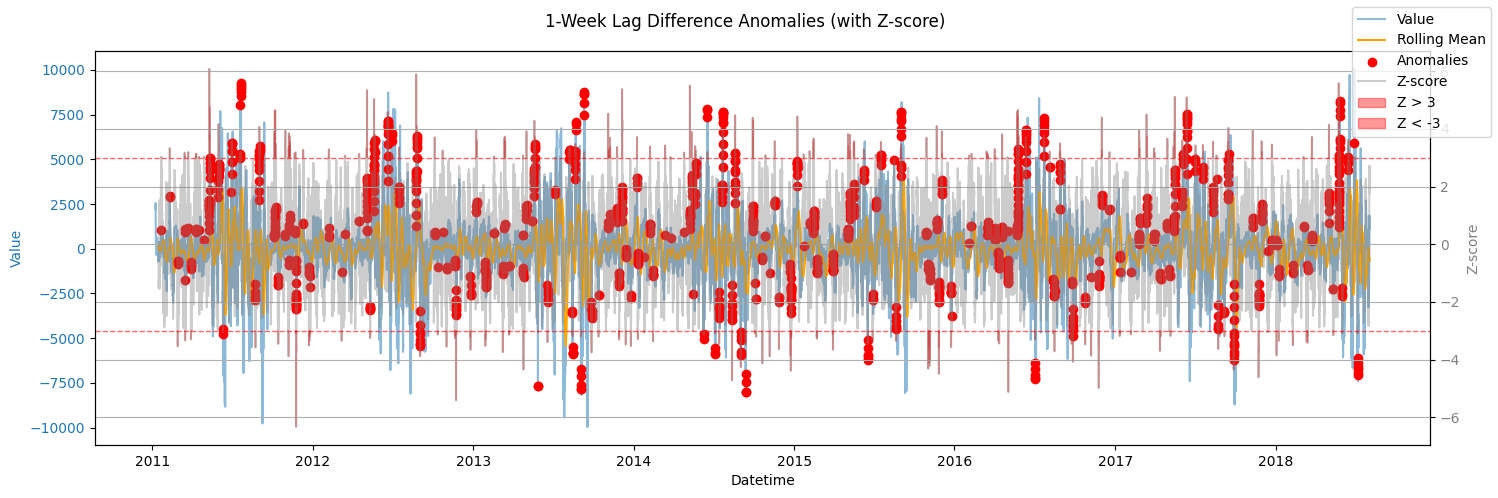

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("COMED_hourly.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)

# Utility: Anomaly detection function
def detect_anomalies(df, column='COMED_MW', window=30, z_thresh=3):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    z_score = (df[column] - rolling_mean) / rolling_std
    anomalies = z_score.abs() > z_thresh
    return pd.DataFrame({
        'Datetime': df['Datetime'],
        'value': df[column],
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'z_score': z_score,
        'anomaly': anomalies
    })

# === 1. Hourly ===
hourly = df.copy()
hourly_result = detect_anomalies(hourly, window=24*7)  # 1 week window

# === 2. Daily ===
daily = df.resample('D', on='Datetime').sum().reset_index()
daily_result = detect_anomalies(daily, column='COMED_MW', window=30)

# === 3. Monthly ===
monthly = df.resample('ME', on='Datetime').sum().reset_index()
monthly_result = detect_anomalies(monthly, column='COMED_MW', window=6)

# === 4. 1-hour lag ===
df['lag_1h'] = df['COMED_MW'].shift(1)
df['diff_1h'] = df['COMED_MW'] - df['lag_1h']
lag1h_result = detect_anomalies(df.dropna(subset=['diff_1h']), column='diff_1h', window=24*7)

# === 5. 1-day lag ===
df['lag_1d'] = df['COMED_MW'].shift(24)
df['diff_1d'] = df['COMED_MW'] - df['lag_1d']
lag1d_result = detect_anomalies(df.dropna(subset=['diff_1d']), column='diff_1d', window=24*7)

# === 6. 1-week lag ===
df['lag_1w'] = df['COMED_MW'].shift(24*7)
df['diff_1w'] = df['COMED_MW'] - df['lag_1w']
lag1w_result = detect_anomalies(df.dropna(subset=['diff_1w']), column='diff_1w', window=24*7)

def plot_anomalies_dual_axis(df_result, title):
    fig, ax1 = plt.subplots(figsize=(15, 5))
    fig.canvas.manager.set_window_title(title)

    # Primary Y-axis: Actual values and rolling mean
    ax1.set_xlabel("Datetime")
    ax1.set_ylabel("Value", color='tab:blue')
    ax1.plot(df_result['Datetime'], df_result['value'], label='Value', color='tab:blue', alpha=0.5)
    ax1.plot(df_result['Datetime'], df_result['rolling_mean'], label='Rolling Mean', color='orange')
    ax1.scatter(df_result[df_result['anomaly']]['Datetime'],
                df_result[df_result['anomaly']]['value'],
                color='red', label='Anomalies', zorder=5)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Secondary Y-axis: Z-score
    ax2 = ax1.twinx()
    ax2.set_ylabel("Z-score", color='tab:gray')
    ax2.plot(df_result['Datetime'], df_result['z_score'], label='Z-score', color='gray', alpha=0.4)
    ax2.axhline(3, color='red', linestyle='--', linewidth=1, alpha=0.6)
    ax2.axhline(-3, color='red', linestyle='--', linewidth=1, alpha=0.6)
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Shaded areas for z-score anomalies with increased alpha for better visibility
    ax2.fill_between(df_result['Datetime'],
                     3,
                     df_result['z_score'],
                     where=(df_result['z_score'] > 3),
                     interpolate=True,
                     color='red',
                     alpha=0.4,  # Increased alpha for visibility
                     label='Z > 3')

    ax2.fill_between(df_result['Datetime'],
                     -3,
                     df_result['z_score'],
                     where=(df_result['z_score'] < -3),
                     interpolate=True,
                     color='red',
                     alpha=0.4,  # Increased alpha for visibility
                     label='Z < -3')

    # Title and layout
    fig.suptitle(title)
    fig.tight_layout()
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# 🔁 Call the function for each dataset
plot_anomalies_dual_axis(hourly_result, "Hourly Anomalies (with Z-score)")
plot_anomalies_dual_axis(daily_result, "Daily Anomalies (with Z-score)")
plot_anomalies_dual_axis(monthly_result, "Monthly Anomalies (with Z-score)")
plot_anomalies_dual_axis(lag1h_result, "1-Hour Lag Difference Anomalies (with Z-score)")
plot_anomalies_dual_axis(lag1d_result, "1-Day Lag Difference Anomalies (with Z-score)")
plot_anomalies_dual_axis(lag1w_result, "1-Week Lag Difference Anomalies (with Z-score)")

# Save anomaly results to CSV
hourly_result.to_csv("hourly_anomalies_z_score.csv", index=False)
daily_result.to_csv("daily_anomalies_z_score.csv", index=False)
monthly_result.to_csv("monthly_anomalies_z_score.csv", index=False)
lag1h_result.to_csv("lag1h_anomalies_z_score.csv", index=False)
lag1d_result.to_csv("lag1d_anomalies_z_score.csv", index=False)
lag1w_result.to_csv("lag1w_anomalies_z_score.csv", index=False)

### 2. Interquartile range

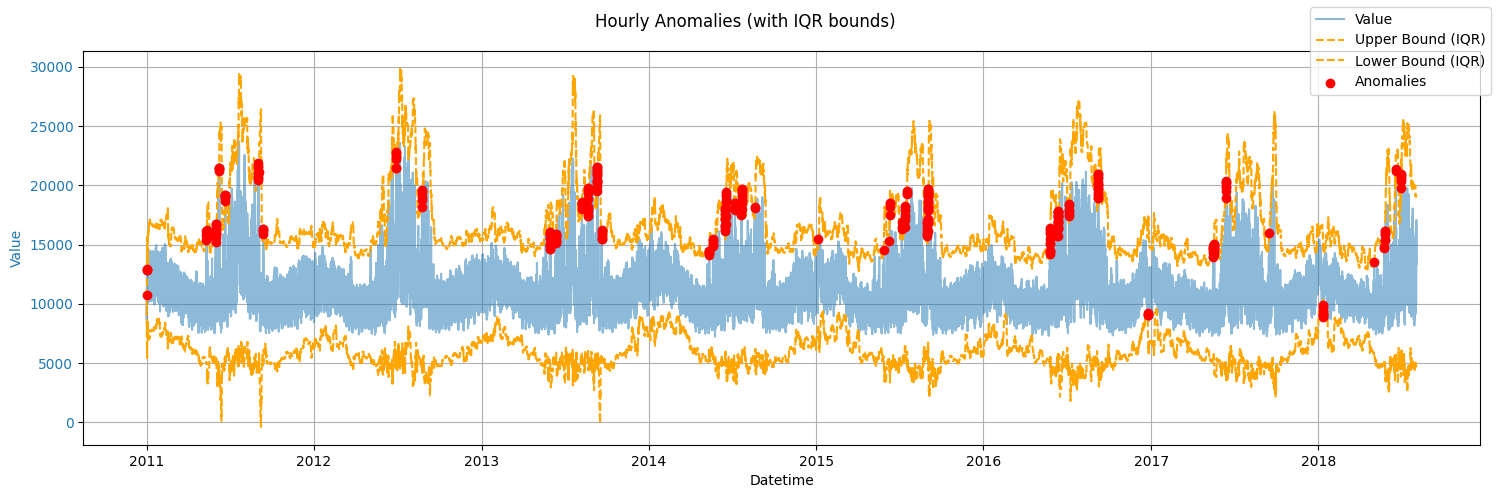

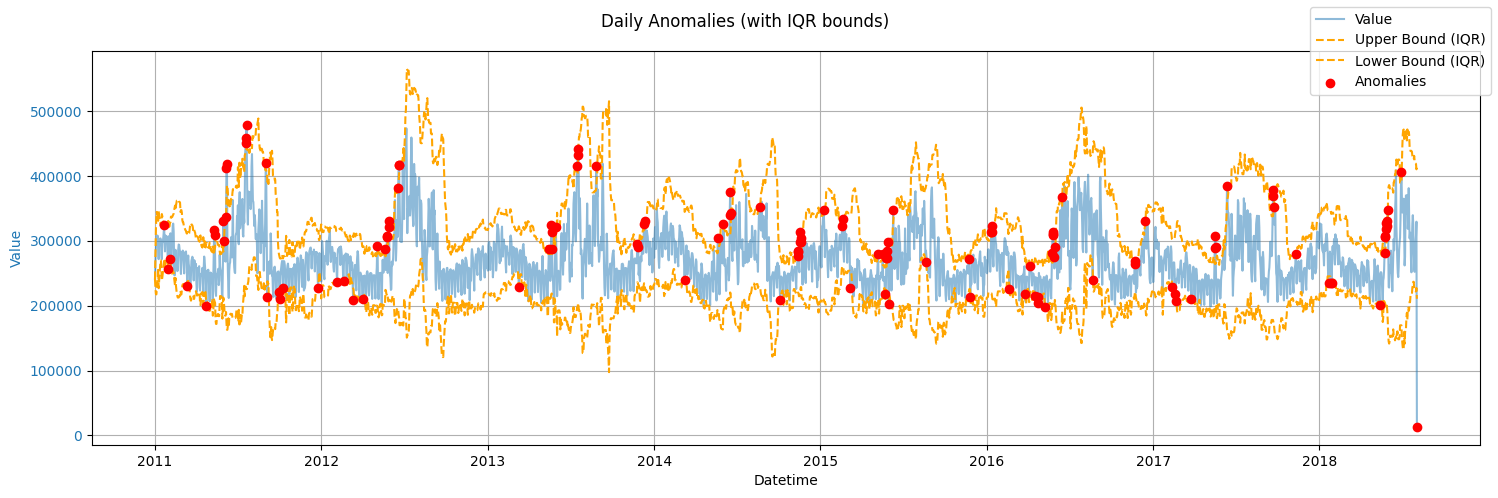

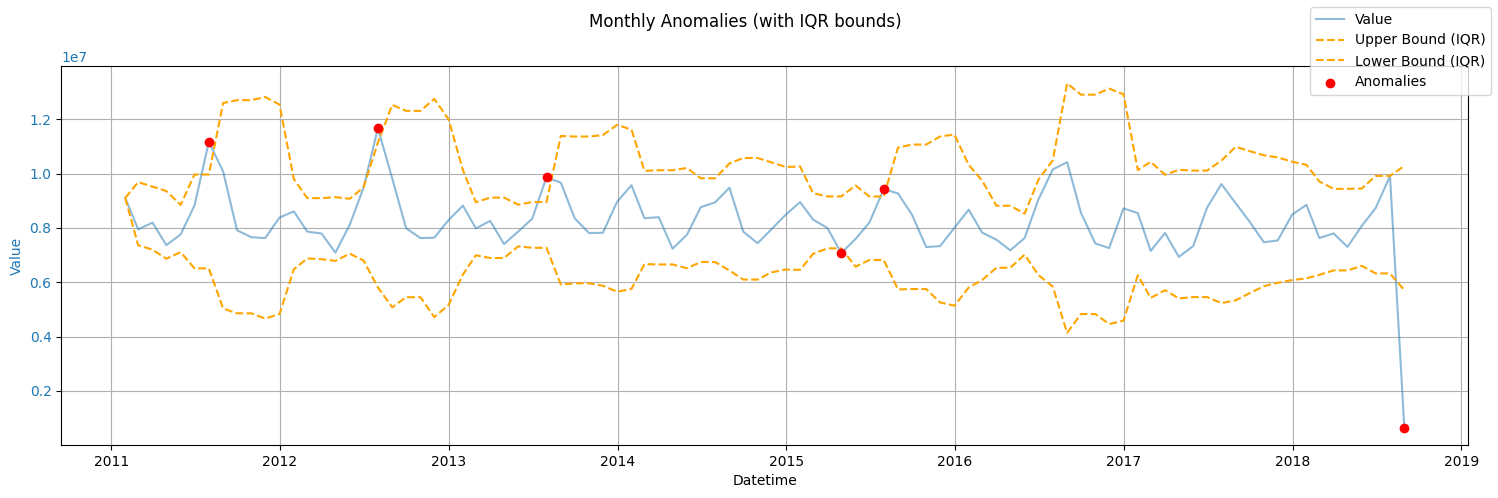

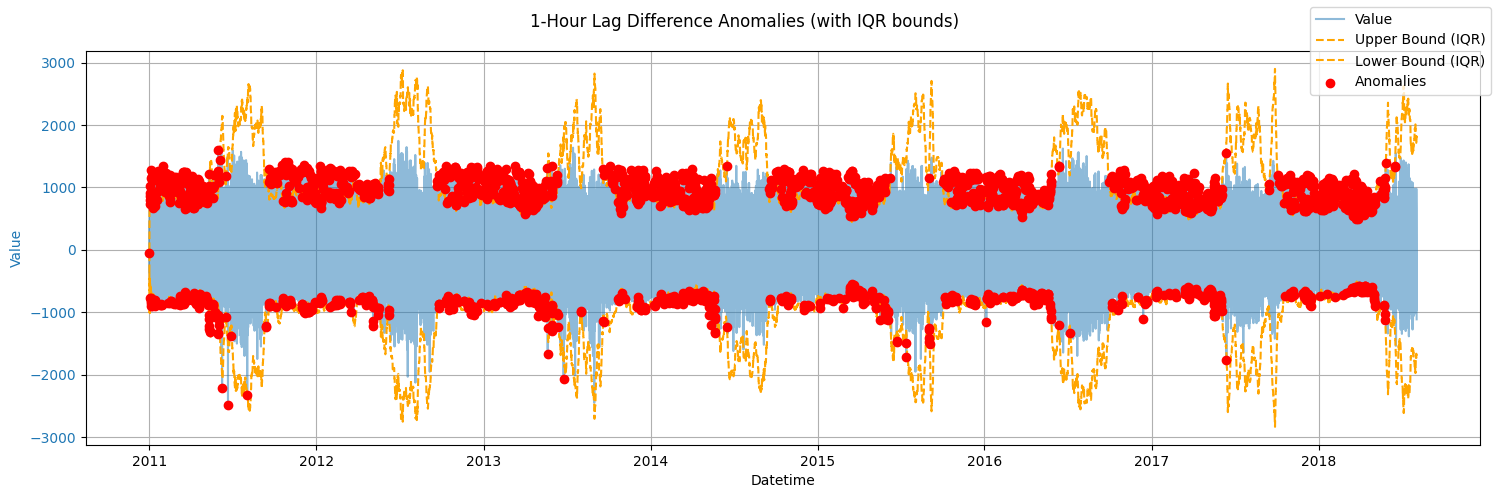

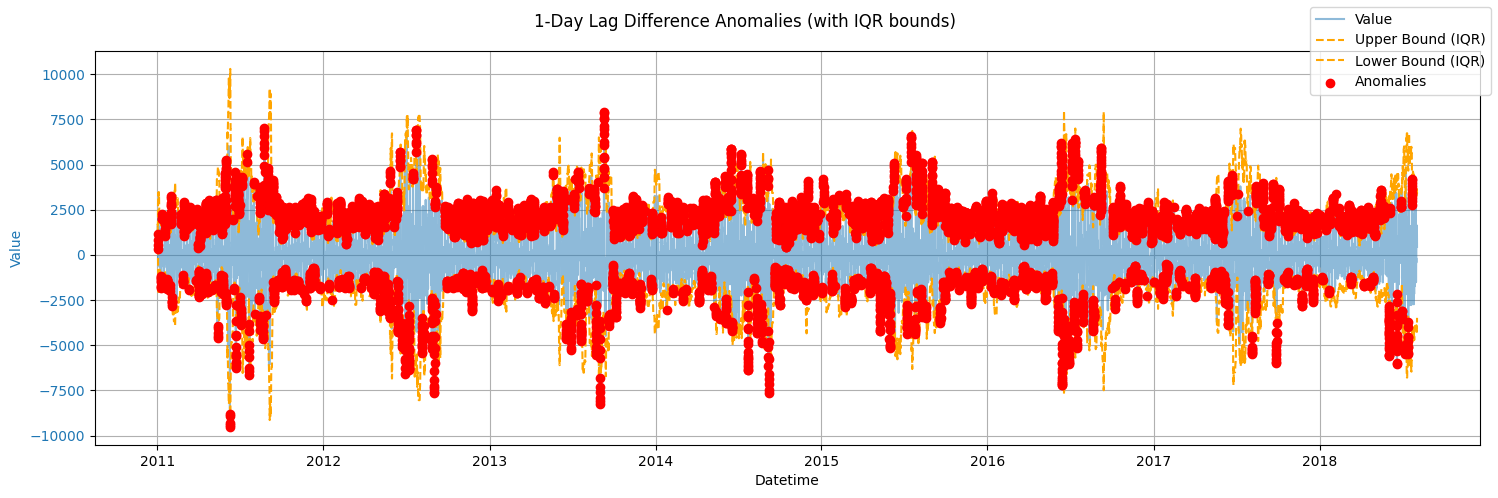

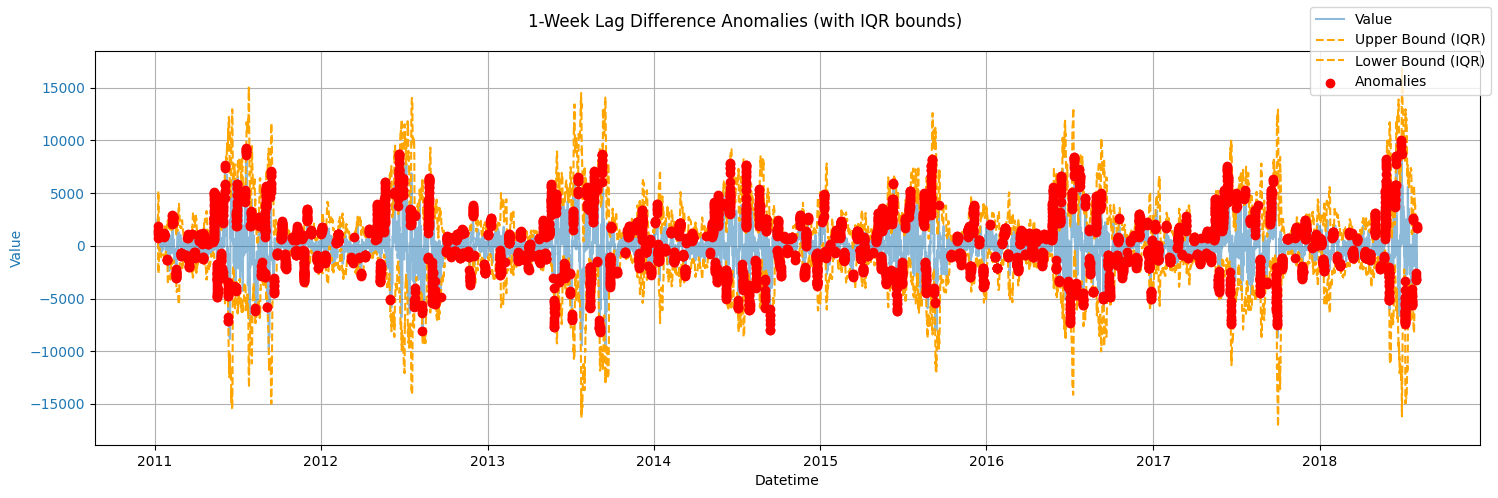

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("COMED_hourly.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)

# Utility: Anomaly detection function using IQR method
def detect_anomalies_iqr(df, column='COMED_MW', window=30):
    rolling_data = df[column].rolling(window=window, min_periods=1)
    Q1 = rolling_data.quantile(0.25)
    Q3 = rolling_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate bounds for anomalies using IQR method
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Anomalies are values outside the IQR bounds
    anomalies = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    return pd.DataFrame({
        'Datetime': df['Datetime'],
        'value': df[column],
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'anomaly': anomalies
    })

# === 1. Hourly ===
hourly = df.copy()
hourly_result = detect_anomalies_iqr(hourly, window=24*7)  # 1-week window

# === 2. Daily ===
daily = df.resample('D', on='Datetime').sum().reset_index()
daily_result = detect_anomalies_iqr(daily, column='COMED_MW', window=30)

# === 3. Monthly ===
monthly = df.resample('ME', on='Datetime').sum().reset_index()
monthly_result = detect_anomalies_iqr(monthly, column='COMED_MW', window=6)

# === 4. 1-hour lag ===
df['lag_1h'] = df['COMED_MW'].shift(1)
df['diff_1h'] = df['COMED_MW'] - df['lag_1h']
lag1h_result = detect_anomalies_iqr(df.dropna(subset=['diff_1h']), column='diff_1h', window=24*7)

# === 5. 1-day lag ===
df['lag_1d'] = df['COMED_MW'].shift(24)
df['diff_1d'] = df['COMED_MW'] - df['lag_1d']
lag1d_result = detect_anomalies_iqr(df.dropna(subset=['diff_1d']), column='diff_1d', window=24*7)

# === 6. 1-week lag ===
df['lag_1w'] = df['COMED_MW'].shift(24*7)
df['diff_1w'] = df['COMED_MW'] - df['lag_1w']
lag1w_result = detect_anomalies_iqr(df.dropna(subset=['diff_1w']), column='diff_1w', window=24*7)

# Plot anomalies using the IQR method
def plot_anomalies_iqr(df_result, title):
    fig, ax1 = plt.subplots(figsize=(15, 5))
    fig.canvas.manager.set_window_title(title)

    # Primary Y-axis: Actual values and rolling IQR bounds
    ax1.set_xlabel("Datetime")
    ax1.set_ylabel("Value", color='tab:blue')
    ax1.plot(df_result['Datetime'], df_result['value'], label='Value', color='tab:blue', alpha=0.5)
    ax1.plot(df_result['Datetime'], df_result['upper_bound'], label='Upper Bound (IQR)', color='orange', linestyle='--')
    ax1.plot(df_result['Datetime'], df_result['lower_bound'], label='Lower Bound (IQR)', color='orange', linestyle='--')
    ax1.scatter(df_result[df_result['anomaly']]['Datetime'],
                df_result[df_result['anomaly']]['value'],
                color='red', label='Anomalies', zorder=5)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Title and layout
    fig.suptitle(title)
    fig.tight_layout()
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# 🔁 Call the function for each dataset
plot_anomalies_iqr(hourly_result, "Hourly Anomalies (with IQR bounds)")
plot_anomalies_iqr(daily_result, "Daily Anomalies (with IQR bounds)")
plot_anomalies_iqr(monthly_result, "Monthly Anomalies (with IQR bounds)")
plot_anomalies_iqr(lag1h_result, "1-Hour Lag Difference Anomalies (with IQR bounds)")
plot_anomalies_iqr(lag1d_result, "1-Day Lag Difference Anomalies (with IQR bounds)")
plot_anomalies_iqr(lag1w_result, "1-Week Lag Difference Anomalies (with IQR bounds)")

# Save anomaly results to CSV
hourly_result.to_csv("hourly_anomalies_iqr.csv", index=False)
daily_result.to_csv("daily_anomalies_iqr.csv", index=False)
monthly_result.to_csv("monthly_anomalies_iqr.csv", index=False)
lag1h_result.to_csv("lag1h_anomalies_iqr.csv", index=False)
lag1d_result.to_csv("lag1d_anomalies_iqr.csv", index=False)
lag1w_result.to_csv("lag1w_anomalies_iqr.csv", index=False)

### 3. Median absolute deviation

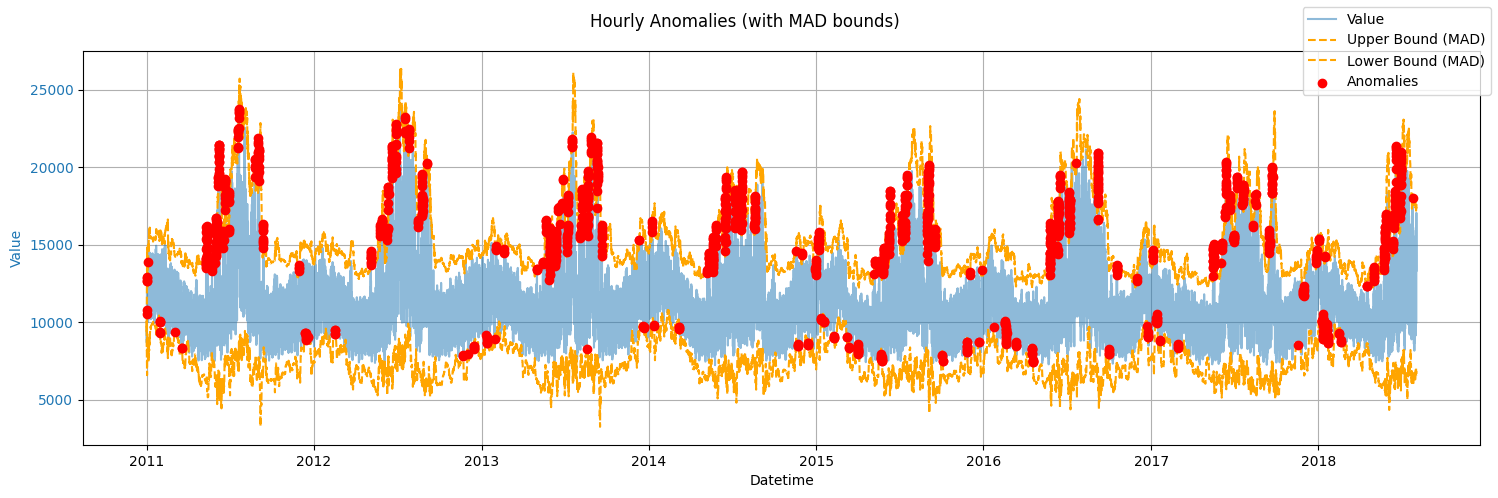

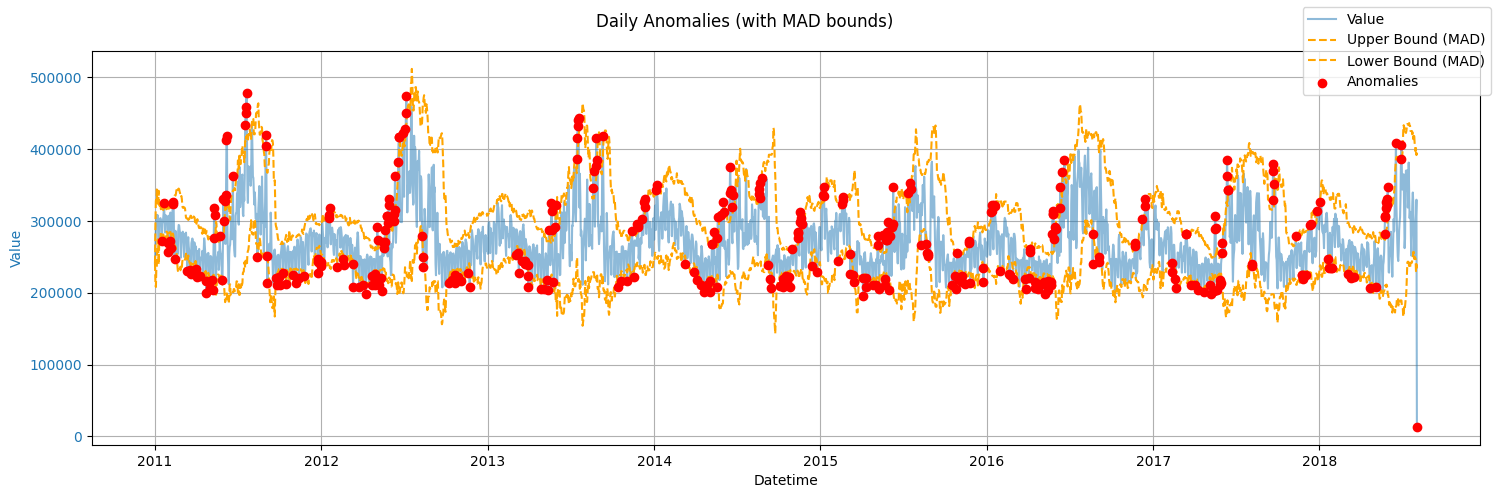

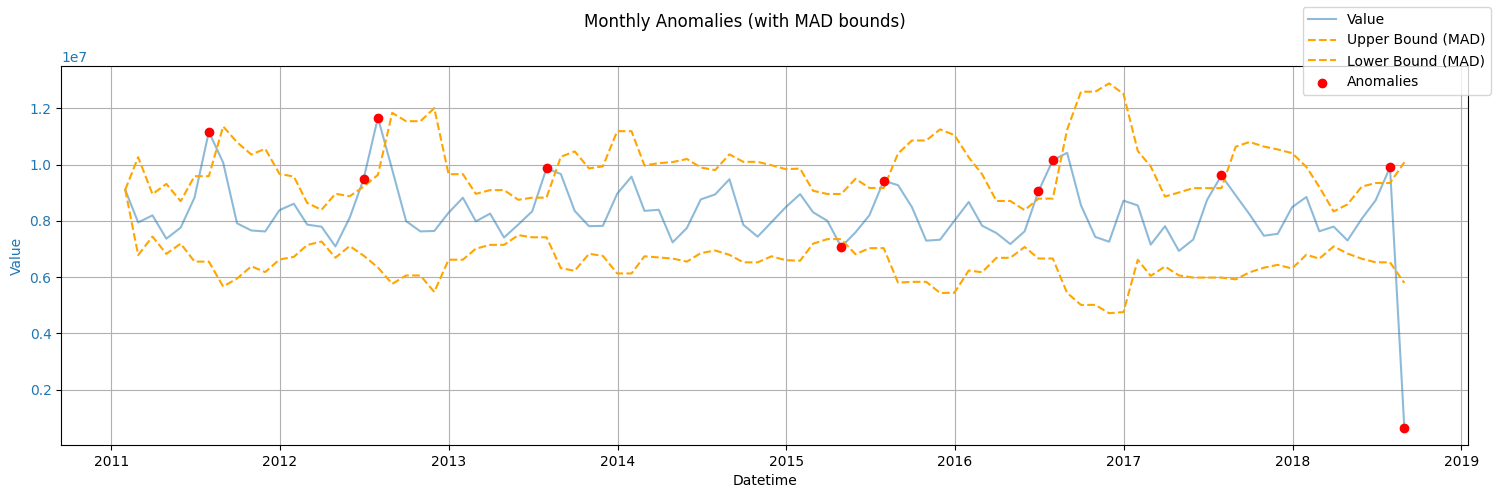

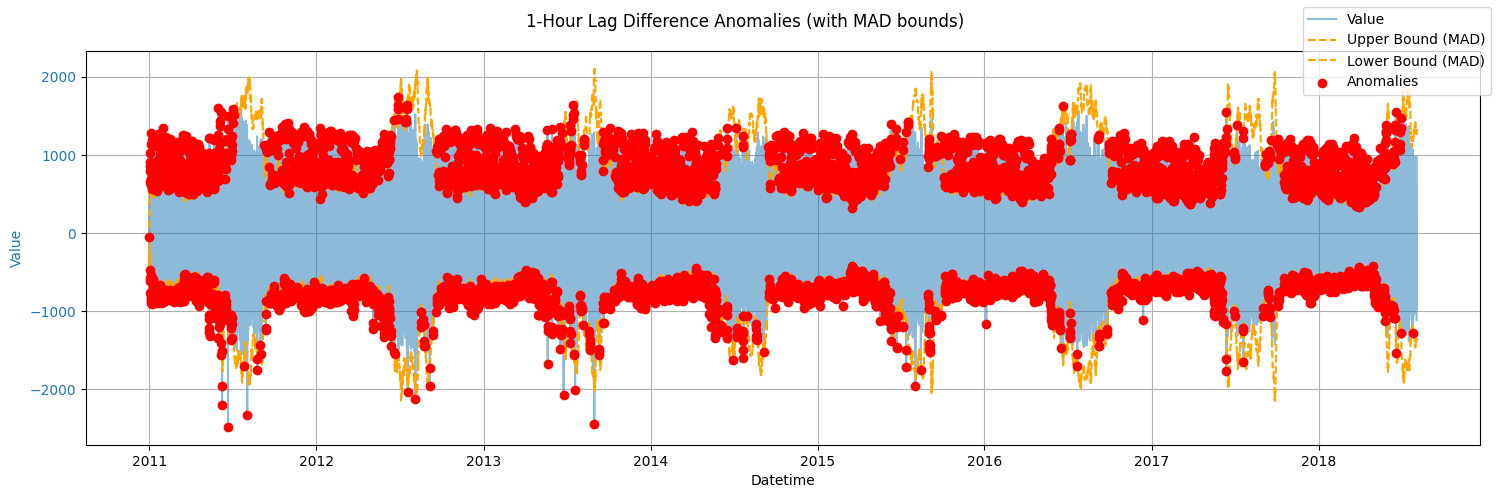

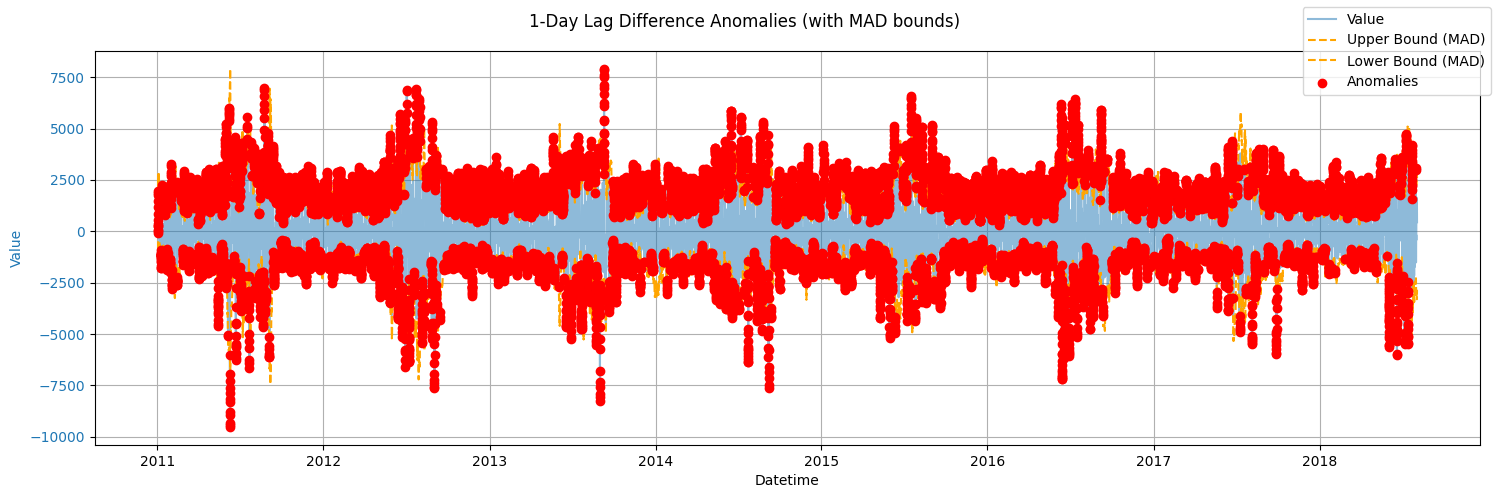

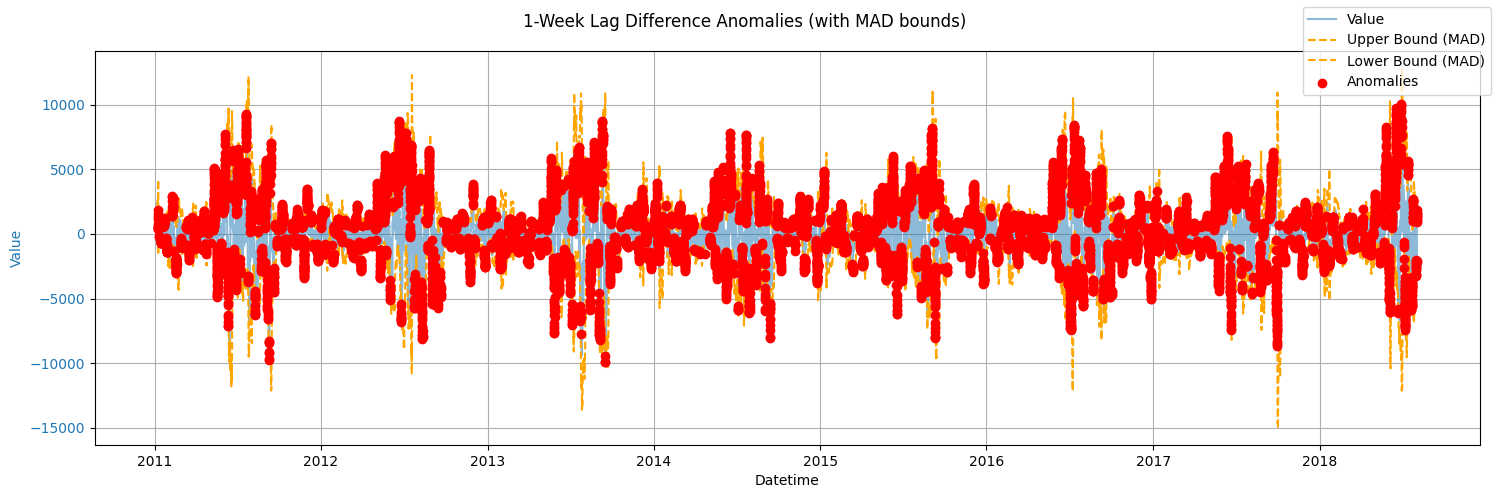

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("COMED_hourly.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)

# Utility: Anomaly detection function using MAD method
def detect_anomalies_mad(df, column='COMED_MW', window=30, threshold=3):
    rolling_data = df[column].rolling(window=window, min_periods=1)
    
    # Calculate the median and the absolute deviation from the median
    median = rolling_data.median()
    mad = (rolling_data.apply(lambda x: np.median(np.abs(x - np.median(x)))))

    # Calculate bounds for anomalies using MAD method
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    
    # Anomalies are values outside the MAD bounds
    anomalies = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    return pd.DataFrame({
        'Datetime': df['Datetime'],
        'value': df[column],
        'median': median,
        'mad': mad,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'anomaly': anomalies
    })

# === 1. Hourly ===
hourly = df.copy()
hourly_result = detect_anomalies_mad(hourly, window=24*7)  # 1-week window

# === 2. Daily ===
daily = df.resample('D', on='Datetime').sum().reset_index()
daily_result = detect_anomalies_mad(daily, column='COMED_MW', window=30)

# === 3. Monthly ===
monthly = df.resample('ME', on='Datetime').sum().reset_index()
monthly_result = detect_anomalies_mad(monthly, column='COMED_MW', window=6)

# === 4. 1-hour lag ===
df['lag_1h'] = df['COMED_MW'].shift(1)
df['diff_1h'] = df['COMED_MW'] - df['lag_1h']
lag1h_result = detect_anomalies_mad(df.dropna(subset=['diff_1h']), column='diff_1h', window=24*7)

# === 5. 1-day lag ===
df['lag_1d'] = df['COMED_MW'].shift(24)
df['diff_1d'] = df['COMED_MW'] - df['lag_1d']
lag1d_result = detect_anomalies_mad(df.dropna(subset=['diff_1d']), column='diff_1d', window=24*7)

# === 6. 1-week lag ===
df['lag_1w'] = df['COMED_MW'].shift(24*7)
df['diff_1w'] = df['COMED_MW'] - df['lag_1w']
lag1w_result = detect_anomalies_mad(df.dropna(subset=['diff_1w']), column='diff_1w', window=24*7)

# Plot anomalies using the MAD method
def plot_anomalies_mad(df_result, title):
    fig, ax1 = plt.subplots(figsize=(15, 5))
    fig.canvas.manager.set_window_title(title)

    # Primary Y-axis: Actual values and rolling MAD bounds
    ax1.set_xlabel("Datetime")
    ax1.set_ylabel("Value", color='tab:blue')
    ax1.plot(df_result['Datetime'], df_result['value'], label='Value', color='tab:blue', alpha=0.5)
    ax1.plot(df_result['Datetime'], df_result['upper_bound'], label='Upper Bound (MAD)', color='orange', linestyle='--')
    ax1.plot(df_result['Datetime'], df_result['lower_bound'], label='Lower Bound (MAD)', color='orange', linestyle='--')
    ax1.scatter(df_result[df_result['anomaly']]['Datetime'],
                df_result[df_result['anomaly']]['value'],
                color='red', label='Anomalies', zorder=5)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Title and layout
    fig.suptitle(title)
    fig.tight_layout()
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# 🔁 Call the function for each dataset
plot_anomalies_mad(hourly_result, "Hourly Anomalies (with MAD bounds)")
plot_anomalies_mad(daily_result, "Daily Anomalies (with MAD bounds)")
plot_anomalies_mad(monthly_result, "Monthly Anomalies (with MAD bounds)")
plot_anomalies_mad(lag1h_result, "1-Hour Lag Difference Anomalies (with MAD bounds)")
plot_anomalies_mad(lag1d_result, "1-Day Lag Difference Anomalies (with MAD bounds)")
plot_anomalies_mad(lag1w_result, "1-Week Lag Difference Anomalies (with MAD bounds)")

# Save anomaly results to CSV
hourly_result.to_csv("hourly_anomalies_mad.csv", index=False)
daily_result.to_csv("daily_anomalies_mad.csv", index=False)
monthly_result.to_csv("monthly_anomalies_mad.csv", index=False)
lag1h_result.to_csv("lag1h_anomalies_mad.csv", index=False)
lag1d_result.to_csv("lag1d_anomalies_mad.csv", index=False)
lag1w_result.to_csv("lag1w_anomalies_mad.csv", index=False)